4.2

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import tensorflow as tf
print(tf.__version__)

4.3

In [ ]:
import tensorflow_datasets as tfds

tfds.__version__

https://www.tensorflow.org/datasets/catalog/overview   
Audio   
Image   
Image classification   
Object detection   
Question answering   
Structured   
Summarization   
Text   
Translate   
Video   

cats_vs_dogs data 사용 예정   
https://www.tensorflow.org/datasets/catalog/cats_vs_dogs   
다운로드 크기 : 786.68 MiB   
1738개 데이터   

In [21]:
(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]','train[80%:90%]','train[90%:]'],
    with_info=True,
    as_supervised=True,
)

In [22]:
print(raw_train)
print(raw_validation)
print(raw_test)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


4.4

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [ ]:
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(raw_train.take(10)):
    plt.subplot(2, 5, idx+1)
    plt.imshow(image)
    plt.title(f'label {label}:{get_label_name(label)}')
    plt.axis('off')

이미지 사이즈 160x160 픽셀로 통일시키고, 각 픽셀값의 scale을 수정하는 역할

In [24]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

/127.5) -1 의 의미   
0부터 255까지의 RGB 픽셀값을 -1~1로 바꿔주는 일종의 표준화 작업

In [25]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

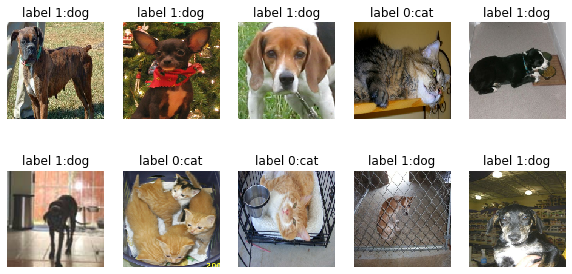

In [26]:
plt.figure(figsize=(10,5))

get_label_name = metadata.features['label'].int2str

for idx, (image, label) in enumerate(train.take(10)):
    plt.subplot(2, 5, idx+1)
    image = (image + 1) / 2 #추가된 부분, 픽셀값이 모두 양수가 되도록.
    plt.imshow(image)
    plt.title(f'label {label}:{get_label_name(label)}')
    plt.axis('off')

4.5

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

In [31]:
model = Sequential([
    Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(160, 160, 3)),
    MaxPooling2D(),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [ ]:
model.summary()

이미지 한 장이 입력되면 그 이미지는 Convolutional(합성곱) 연산을 통해 그 형태가 점점 길쭉해지다가, Flatten 레이어를 만나면 오른쪽처럼 한 줄로 펴지는 것. 3차원의 이미지가 1차원으로 펼쳐짐

In [32]:
import numpy as np

image = np.array([[1,2],[3,4]])
print(image.shape)
image

(2, 2)


array([[1, 2],
       [3, 4]])

In [33]:
image.flatten()

array([1, 2, 3, 4])

4.6   
학습률 파라미터를 지정후 모델 컴파일하여 학습할 수 있는 형태로 변환

In [34]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

__compile을 하기 위해 필요한 것들 세 가지__   

__optimizer__ 학습을 어떤 방식으로 시킬 것인지 결정   
__loss__ 모델이 학습해나가야 하는 방향을 결정   
__metrics__ 모델의 성능을 평가하는 정도

In [27]:
BATCH_SIZE = 32 #한 스텝에 학습시킬 데이터의 개수
SHUFFLE_BUFFER_SIZE = 1000 #학습 데이터를 적절히 섞어줄 버퍼 사이즈

In [35]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [39]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape, label_batch.shape

(TensorShape([32, 160, 160, 3]), TensorShape([32]))

In [52]:
validation_steps = 20 #20번의 예측
loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 15s 754ms/step - loss: 0.7088 - accuracy: 0.5250
initial loss: 0.71
initial accuracy: 0.52


In [ ]:
EPOCHS = 10
history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

4.7   
학습 단계에 따른 정확도 변화를 그래프로 확인

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuaracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

모델의 예측 결과를 확인하고 싶을 때에는 __model.predict__를 활용

In [29]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

NameError: name 'test_batches' is not defined

prediction값을 실제 추론한 라벨(고양이:0, 강아지:1)로 변환

In [ ]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

각각을 모두 시각화

In [ ]:
plt.figure(figsize=(20,12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image+1)/2
    plt.imshow(image)
    correct = label == prediction
    title = f'real:{label} / pred:{prediction}\n{correct}'
    if not correct:
        plt.title(title, fontdict={'color':'red'})
    else:
        plt.title(title, fontdict={'color':'blue'})
    plt.axis('off')

In [ ]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
     if label == prediction:
            count+=1
    
print(count/32*100)

4.8   
남이 다 해 놓은 걸 갖다 쓰자!   
ILSVRC   
ImageNet Large Scale Visual Recognition Challenge   
   
__전이학습__   
거인의 어깨에 서서 문제를 푼다

4.9   
VGG16 모델을 활용해서 Classifier만 새로 학습

In [36]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D

import numpy as np

IMG_SIZE = 160

In [37]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                        include_top=False,
                                        weights='imagenet')

In [40]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [41]:
feature_batch = base_model(image_batch)
feature_batch.shape

TensorShape([32, 5, 5, 512])

In [42]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

4.10   
Fully connected 레이어로 구성하기 위해서는 1차원 벡터여야함.   
하지만 VGG16이 출력한 것은 5, 5, 512라는 3차원벡터이므로 Flatten 시켜야 함

In [43]:
import numpy as np

image = np.array([[1,2],[3,4]])

flattened_image = image.flatten()

print("Original image:\n", image)
print("Original image shape:", image.shape)
print()
print("Flattened image:\n:", flattened_image)
print("Flattened image shape:", flattened_image.shape)

Original image:
 [[1 2]
 [3 4]]
Original image shape: (2, 2)

Flattened image:
: [1 2 3 4]
Flattened image shape: (4,)


2, 3차원 벡터를 1차원으로 줄이는 더 좋은 방법 : Global Average Pooling

In [10]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [45]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [46]:
dense_layer = tf.keras.layers.Dense(512, activation='relu')
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')

prediction_batch = prediction_layer(dense_layer(feature_batch_average))
print(prediction_batch.shape)

(32, 2)


base_model을 학습시키지 않을 것이므로, trainable 변수를 False로 지정

In [47]:
base_model.trainable = False

In [48]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    dense_layer,
    prediction_layer
])

In [49]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 1026      
Total params: 14,978,370
Trainable params: 263,682
Non-trainable params: 14,714,688
_________________________________________________________________


In [50]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=['accuracy'])

In [53]:
validation_stpes=20
loss0, accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

20/20 [==============================] - 16s 821ms/step - loss: 0.7088 - accuracy: 0.5250
initial loss: 0.71
initial accuracy: 0.52


In [54]:
EPOCHS = 5

history = model.fit(train_batches,
                   epochs=EPOCHS,
                   validation_data=validation_batches)

Epoch 1/5
582/582 [==============================] - 587s 1s/step - loss: 0.2586 - accuracy: 0.9064 - val_loss: 0.1821 - val_accuracy: 0.9265
Epoch 2/5
582/582 [==============================] - 604s 1s/step - loss: 0.1594 - accuracy: 0.9348 - val_loss: 0.1527 - val_accuracy: 0.9342
Epoch 3/5
582/582 [==============================] - 599s 1s/step - loss: 0.1453 - accuracy: 0.9403 - val_loss: 0.1491 - val_accuracy: 0.9411
Epoch 4/5
582/582 [==============================] - 593s 1s/step - loss: 0.1385 - accuracy: 0.9435 - val_loss: 0.1757 - val_accuracy: 0.9261
Epoch 5/5
582/582 [==============================] - 589s 1s/step - loss: 0.1333 - accuracy: 0.9466 - val_loss: 0.1397 - val_accuracy: 0.9437


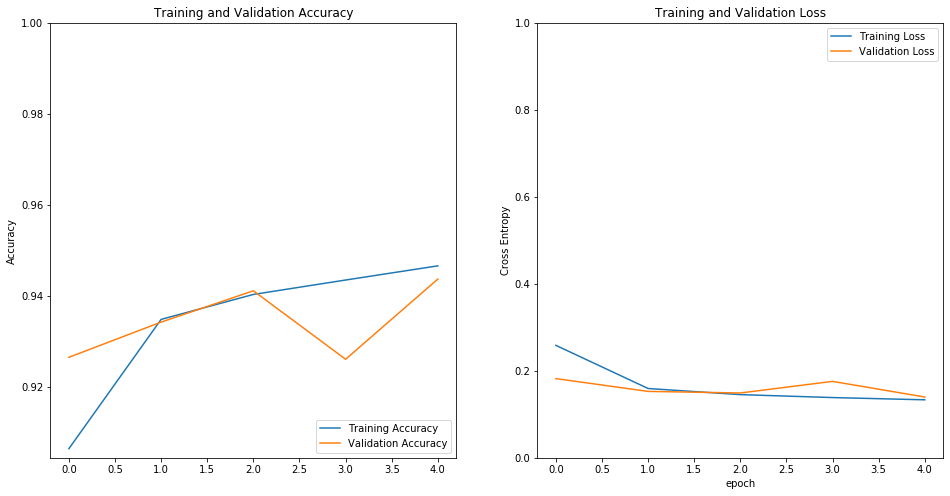

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

32개만 갖고와서 정확도 예측

In [56]:
for image_batch, label_batch in test_batches.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    pass

predictions

array([[9.9998760e-01, 1.2403497e-05],
       [1.2671646e-01, 8.7328357e-01],
       [2.7137873e-01, 7.2862130e-01],
       [9.9999404e-01, 6.0076641e-06],
       [9.9778312e-01, 2.2169352e-03],
       [9.8282951e-01, 1.7170455e-02],
       [1.3395374e-04, 9.9986601e-01],
       [6.5935546e-01, 3.4064445e-01],
       [9.4158638e-01, 5.8413655e-02],
       [9.6137488e-01, 3.8625121e-02],
       [5.5125274e-05, 9.9994493e-01],
       [9.9994934e-01, 5.0692652e-05],
       [9.8661280e-01, 1.3387205e-02],
       [3.1577929e-06, 9.9999690e-01],
       [9.9808037e-01, 1.9196797e-03],
       [9.8462361e-01, 1.5376354e-02],
       [9.9466681e-01, 5.3332094e-03],
       [1.9781739e-02, 9.8021829e-01],
       [6.1096781e-01, 3.8903221e-01],
       [9.9252534e-01, 7.4746069e-03],
       [8.7082243e-01, 1.2917754e-01],
       [9.7290403e-01, 2.7095949e-02],
       [9.9228221e-01, 7.7177486e-03],
       [9.6663141e-01, 3.3368569e-02],
       [9.9812824e-01, 1.8717519e-03],
       [9.7534198e-01, 2.

In [57]:
import numpy as np
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0])

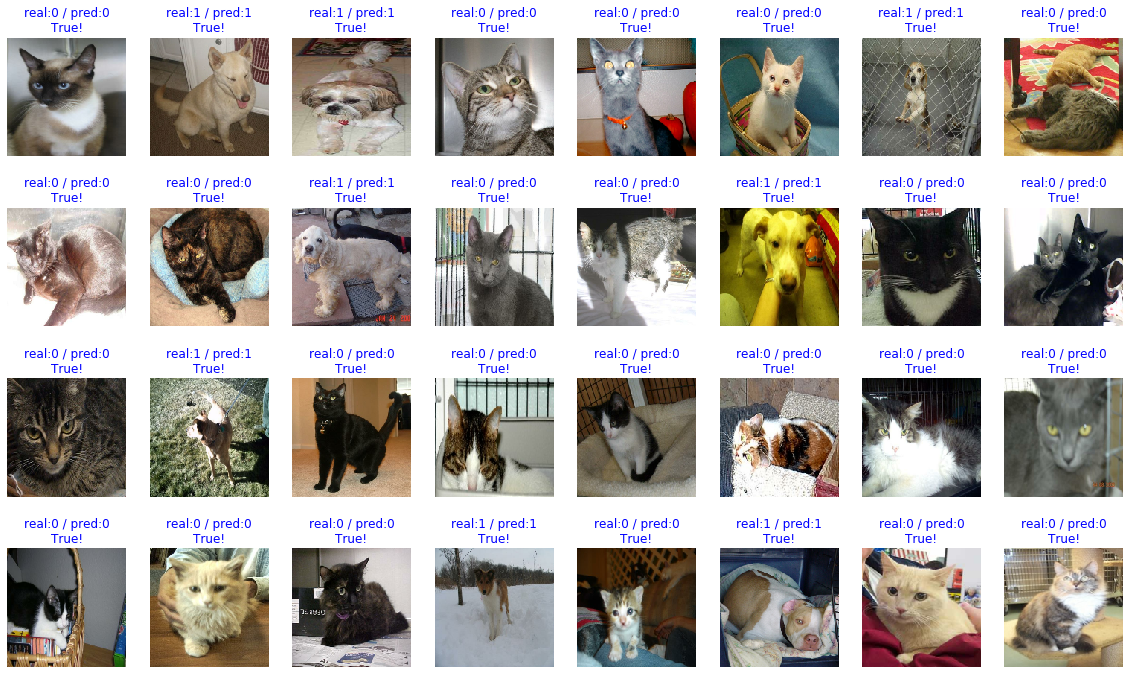

In [58]:
plt.figure(figsize=(20,12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real:{label} / pred:{prediction}\n{correct}!'
    if not correct:
        plt.title(title, fontdict={'color':'red'})
    else:
        plt.title(title, fontdict={'color':'blue'})
    plt.axis('off')

In [59]:
count = 0
for image, label, prediction in zip(images, labels, predictions):
    if label == prediction :
        count = count + 1

print(count / 32 * 100)

100.0


4.12   
모델을 save하고 다시 load해와서 사용하는 방법   
__save_weight__ 함수를 활용하면 모델 저장이 됨. 파라미터로 저장하고 싶은 경로만 입력해주면 됨.   

In [60]:
import os

checkpoint_dir = os.getenv("HOME") + "/aiffel/cat_vs_dog/checkpoint"
checkpoint_file_path = os.path.join(checkpoint_dir, 'checkpoint')

if not os.path.exists('checkpoint_dir'):
    os.mkdir('checkpoint_dir')
    
model.save_weights(checkpoint_file_path)

if os.path.exists(checkpoint_file_path):
    print('checkpoint 파일 생성 OK!!')

checkpoint 파일 생성 OK!!


4.13 새로운 파일 읽어서 분류하기

In [61]:
img_dir_path = os.getenv("HOME") + "/aiffel/cat_vs_dog/images"
os.path.exists(img_dir_path)

True

In [62]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

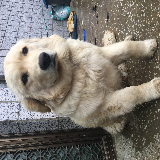

In [63]:
IMG_SIZE = 160
dog_image_path = os.path.join(img_dir_path, 'my_dog.jpeg')

dog_image = load_img(dog_image_path, target_size=(IMG_SIZE, IMG_SIZE))
dog_image

In [64]:
dog_image = img_to_array(dog_image).reshape(1, IMG_SIZE, IMG_SIZE, 3)
dog_image.shape

(1, 160, 160, 3)

In [65]:
prediction = model.predict(dog_image)
prediction

array([[0., 1.]], dtype=float32)

In [66]:
def show_and_predict_image(dirpath, filename, img_size=160):
    filepath = os.path.join(dirpath, filename)
    image = load_img(filepath, target_size=(img_size, img_size))
    plt.imshow(image)
    plt.axis('off')
    image = img_to_array(image).reshape(1, img_size, img_size, 3)
    prediction = model.predict(image)[0]
    cat_percentage = round(prediction[0] * 100)
    print("cat_percentage is ", cat_percentage)
    dog_percentage = round(prediction[1] * 100)
    print("dog_percentage is ", dog_percentage)
    print(f"This image seems {dog_percentage}% dog, and {cat_percentage}% cat.")

cat_percentage is  0.0
dog_percentage is  100.0
This image seems 100.0% dog, and 0.0% cat.


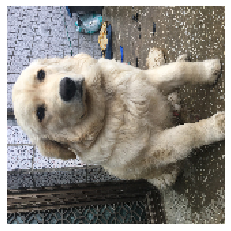

In [67]:
filename = 'my_dog.jpeg'

show_and_predict_image(img_dir_path, filename)

cat_percentage is  0.0
dog_percentage is  100.0
This image seems 100.0% dog, and 0.0% cat.


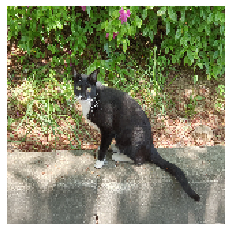

In [68]:
filename = 'my_cat.jpeg'

show_and_predict_image(img_dir_path, filename)

cat_percentage is  0.0
dog_percentage is  100.0
This image seems 100.0% dog, and 0.0% cat.


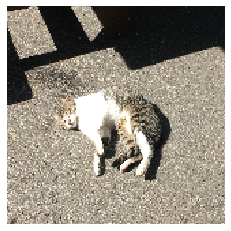

In [69]:
filename = 'my_cat2.jpeg'

show_and_predict_image(img_dir_path, filename)

cat_percentage is  0.0
dog_percentage is  100.0
This image seems 100.0% dog, and 0.0% cat.


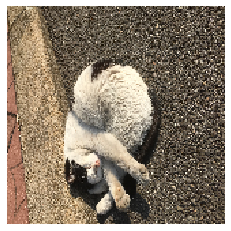

In [70]:
filename = 'my_cat3.jpeg'

show_and_predict_image(img_dir_path, filename)

cat_percentage is  0.0
dog_percentage is  100.0
This image seems 100.0% dog, and 0.0% cat.


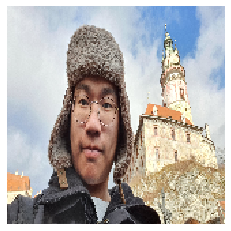

In [71]:
filename = "my_face.jpg"
show_and_predict_image(img_dir_path, filename)

cat_percentage is  0.0
dog_percentage is  100.0
This image seems 100.0% dog, and 0.0% cat.


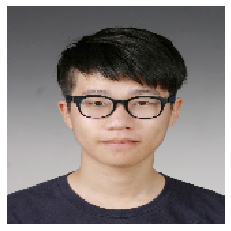

In [72]:
filename = "my_face2.jpg"
show_and_predict_image(img_dir_path, filename)